# Radial Fourier Analysis scripting example

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
%matplotlib nbagg

In [3]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import numpy as np

import libertem.api as lt

In [4]:
ctx = lt.Context()

In [5]:
# Sample data: Metallic glass
# Shuai Wei <shuai.wei@physik.rwth-aachen.de>, RWTH Aachen
# Alexander Kuball, Universität des Saarlandes
# Hongchu Du <h.du@fz-juelich.de>, ER-C, Forschungszentrum Jülich
ds = ctx.load(
    'MIB',
    path='/cachedata/users/du/200_20190328_185735/default.hdr'
)
# ds.shape is (256, 256, 256, 256)
# Size: 8 GB

In [6]:
cx, cy = 134, 129

In [7]:
# These parameters allow running the analysis on a consumer-grade computer
# within a few minutes
# rfa = ctx.create_radial_fourier_analysis(
#     dataset=ds,
#     cx=cx,
#     cy=cy,
#     ri=0,
#     ro=45,
#     n_bins=45,
#     max_order=12
# )

In [8]:
# A workstation with a powerful multicore CPU is more suitable
# for these parameters
rfa = ctx.create_radial_fourier_analysis(
    dataset=ds,
    cx=cx,
    cy=cy,
    ri=0,
    ro=120,
    n_bins=120,
    max_order=36
)

In [9]:
res = ctx.run(rfa)

<IPython.core.display.Javascript object>


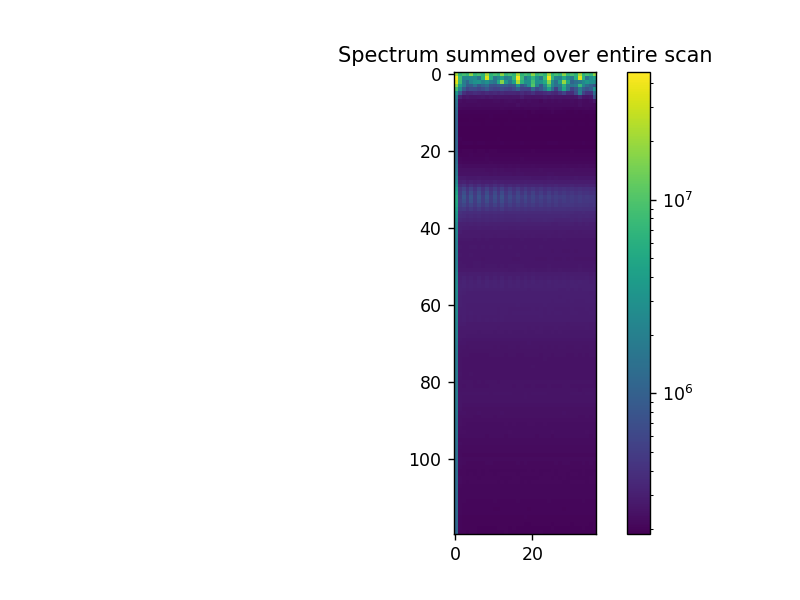

Text(0.5, 1.0, 'Spectrum summed over entire scan')

In [10]:
# Calculate a spectrum for the entire scan as a function of radius

# Note the "abs": The coefficients are complex numbers
# with arbitrary phase angles.
# We sum up the absolute values to ignore orientations,
# otherwise they would cancel each other out.
# Summing the actual values could yield texture information.
spectrum = np.abs(res.raw_results).sum(axis=(2, 3))
fig, axes = plt.subplots()
plt.imshow(spectrum, norm=colors.LogNorm())
plt.colorbar()
plt.title("Spectrum summed over entire scan")

<IPython.core.display.Javascript object>


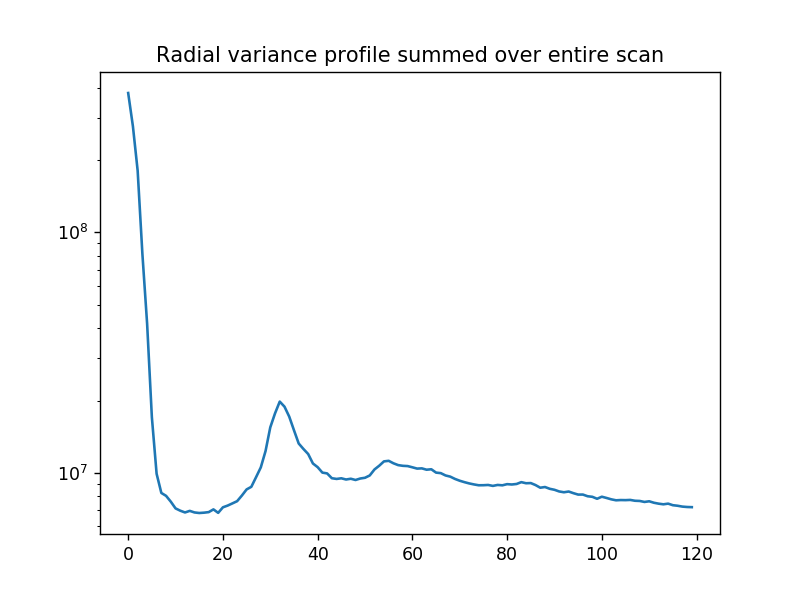

Text(0.5, 1.0, 'Radial variance profile summed over entire scan')

In [11]:
# Summing the absolutes of all non-zero components
# is qualitatively equivalent to the variance, i.e. Fluctuation EM.
# Note: Bins and Fourier transform would have to be normalized correctly
# for this to be quantitatively equivalent to the variance.
radial_variance = spectrum[:, 1:].sum(axis=1)
fig, axes = plt.subplots()
plt.plot(radial_variance)
plt.yscale('log')
plt.title("Radial variance profile summed over entire scan")

<IPython.core.display.Javascript object>


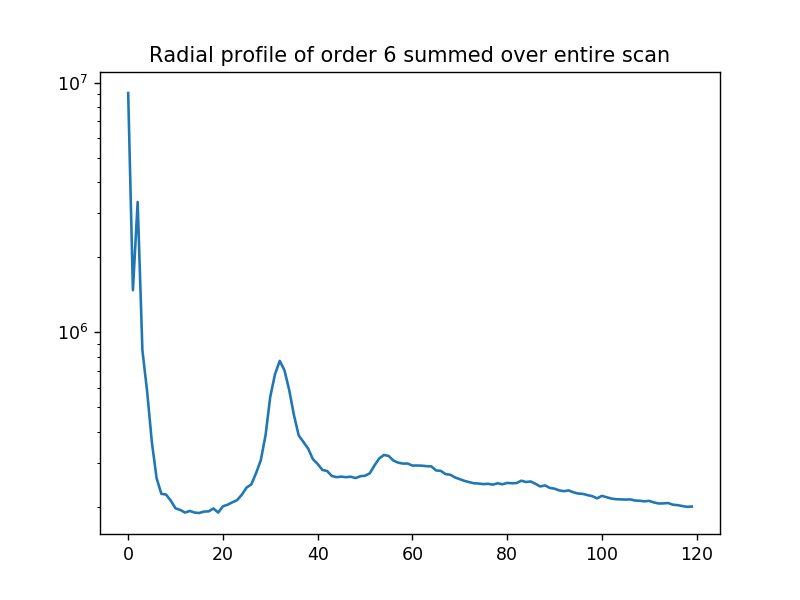

In [12]:
# We can do a radial profile of any order.
radial_six = spectrum[:, 6]
fig, axes = plt.subplots()
plt.title("Radial profile of order 6 summed over entire scan")
plt.plot(radial_six)
plt.yscale('log')

<IPython.core.display.Javascript object>


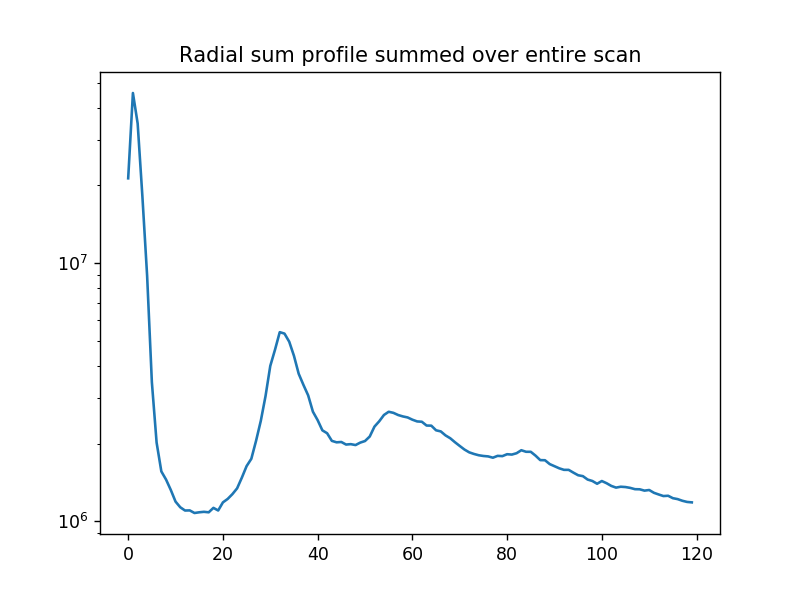

Text(0.5, 1.0, 'Radial sum profile summed over entire scan')

In [13]:
# The zero order component is just the radial sum.
radial_sum = spectrum[:, 0]
fig, axes = plt.subplots()
plt.plot(radial_sum)
plt.yscale('log')
plt.title("Radial sum profile summed over entire scan")

<IPython.core.display.Javascript object>


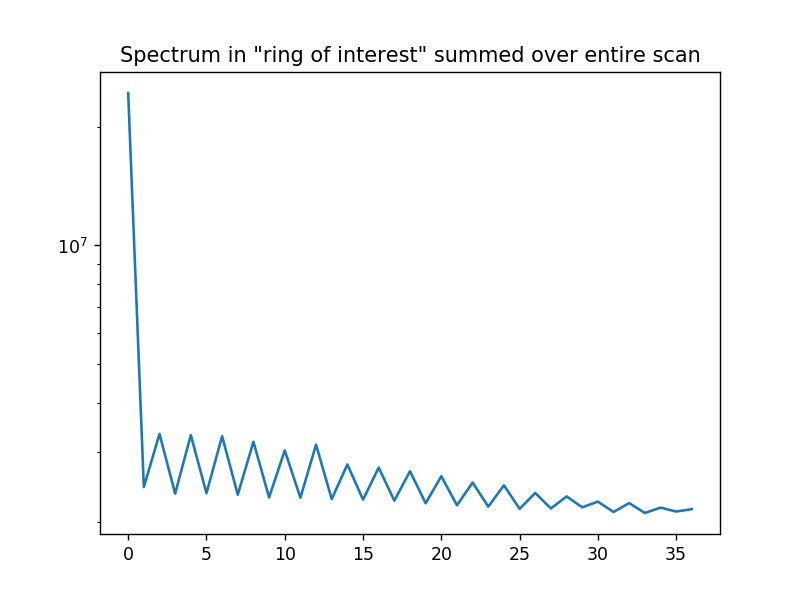

In [14]:
# We determined a "ring of interest" from the radial plots
# or spectrum
ri, ro = 30, 35

# We analyze which coefficients are present in that ring
# Note that the coefficients contain higher harmonics!
# The one with the highest value is of interest.
psd = spectrum[ri:ro].sum(axis=0)
fig, axes = plt.subplots()
plt.plot(psd)
plt.title("Spectrum in \"ring of interest\" summed over entire scan")
plt.yscale('log')

<IPython.core.display.Javascript object>


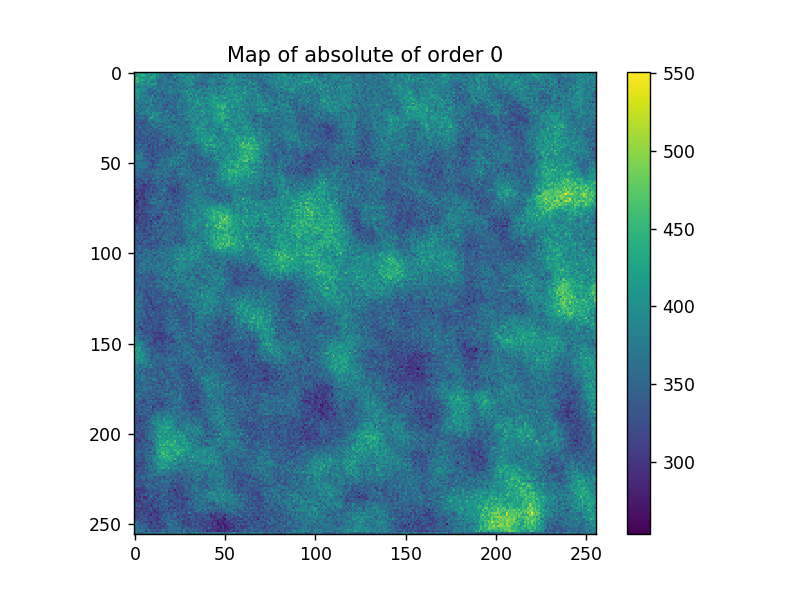

<IPython.core.display.Javascript object>


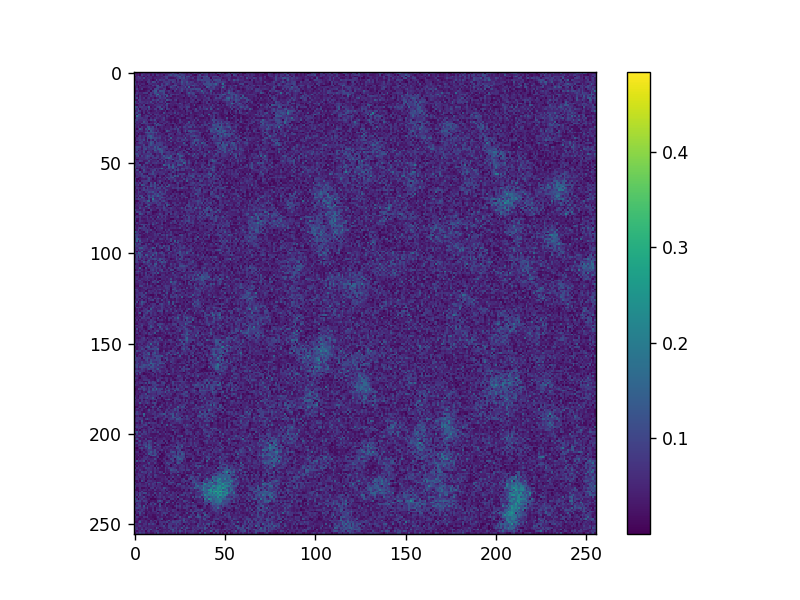

<IPython.core.display.Javascript object>


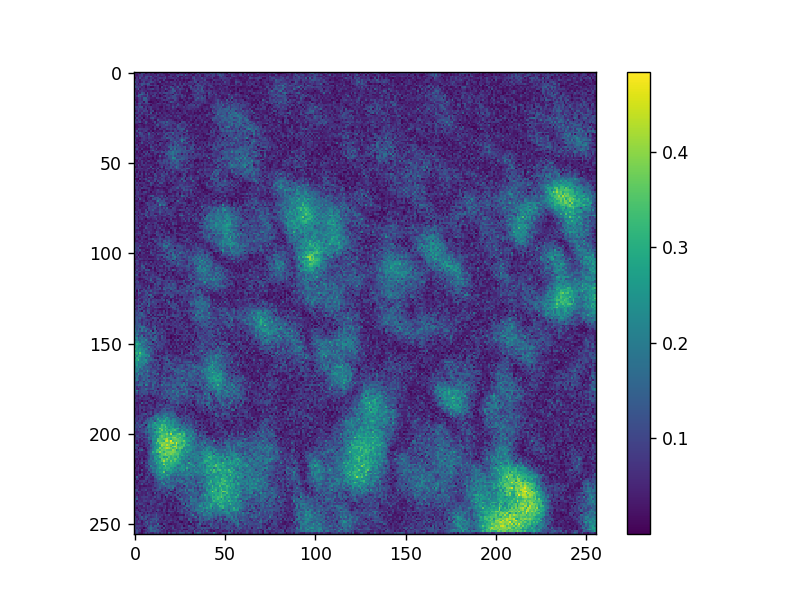

<IPython.core.display.Javascript object>


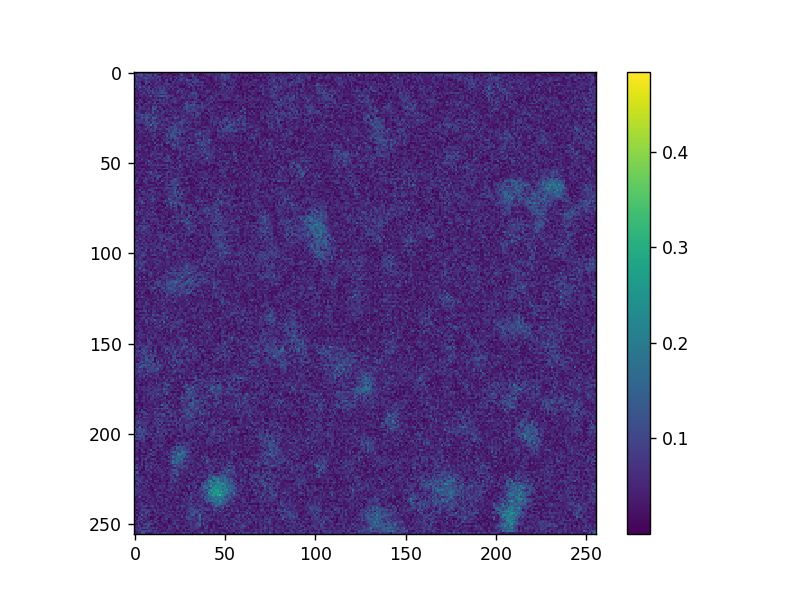

<IPython.core.display.Javascript object>


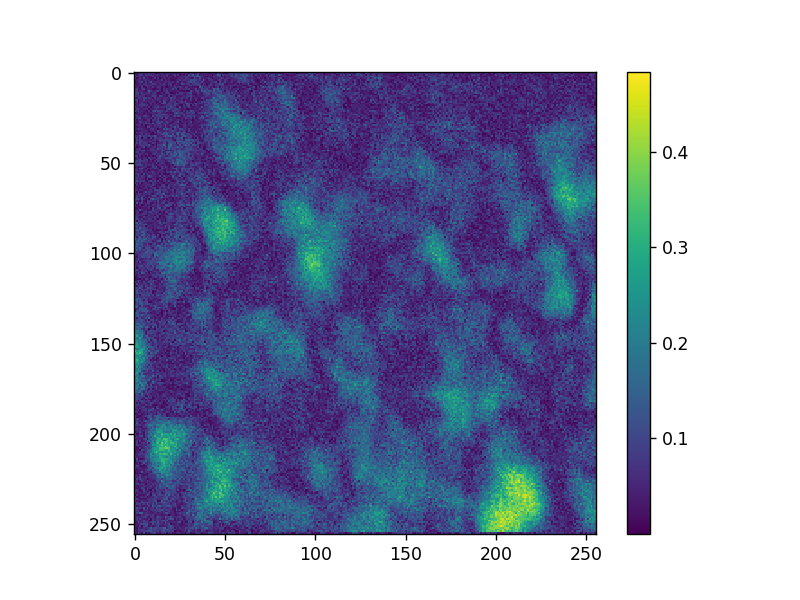

<IPython.core.display.Javascript object>


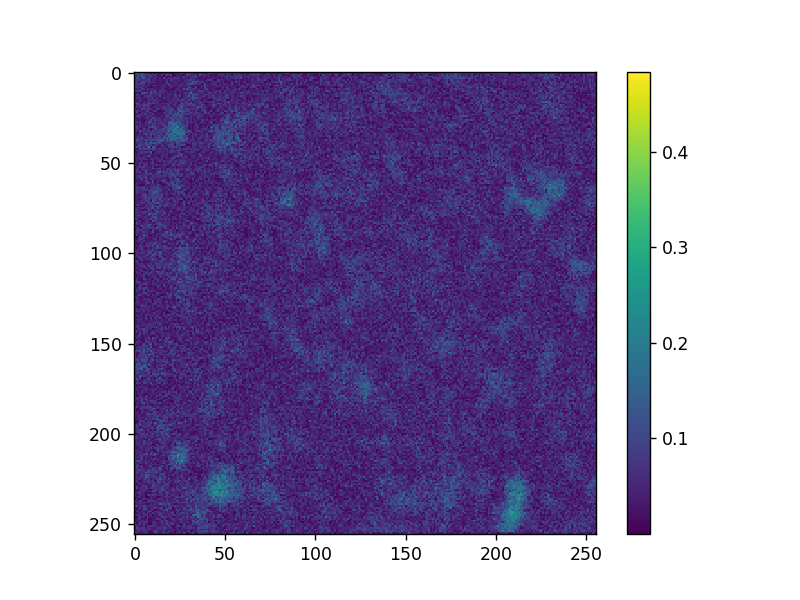

<IPython.core.display.Javascript object>


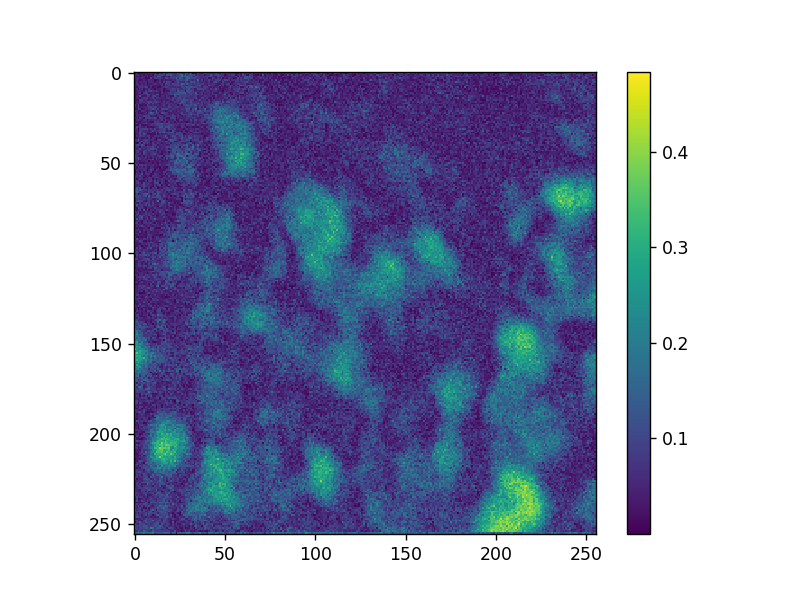

<IPython.core.display.Javascript object>


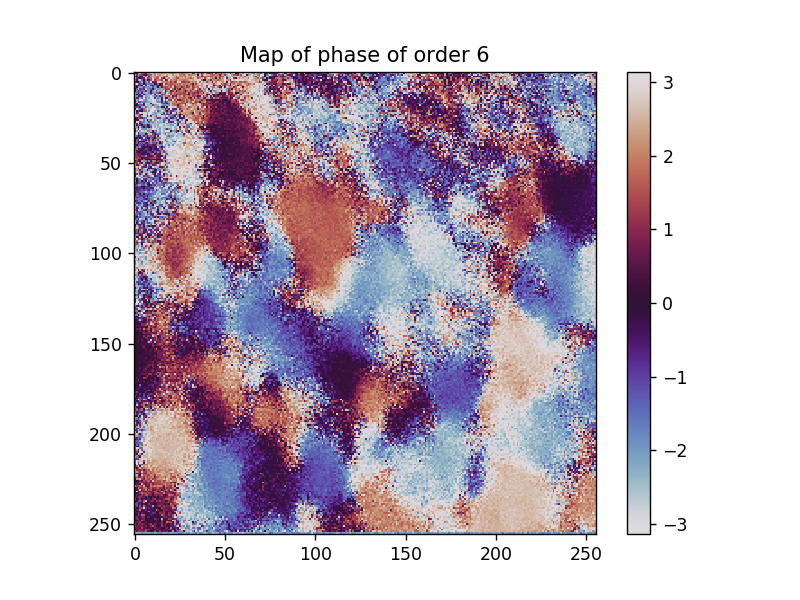

Text(0.5, 1.0, 'Map of phase of order 6')

In [15]:
# We calculate maps for each order across the scan
maps = res.raw_results[ri:ro].sum(axis=0)
# We normalize higher orders with the total integrated intensity
maps[1:] /= np.abs(maps[0])
absmaps = np.abs(maps)

vmin = absmaps[1:].min()
vmax = absmaps[1:].max()

# Plotting the absolute values gives the best overview.
fig, axes = plt.subplots()
plt.imshow(absmaps[0])
plt.colorbar()
plt.title("Map of absolute of order 0")

for o in range(1, 7):
    fig, axes = plt.subplots()
    plt.imshow(absmaps[o], vmin=vmin, vmax=vmax)
    plt.colorbar()

# The phase gives information about orientation
fig, axes = plt.subplots()
plt.imshow(np.angle(maps[o]), cmap=cm.twilight)
plt.colorbar()
plt.title("Map of phase of order %s" % o)

<IPython.core.display.Javascript object>


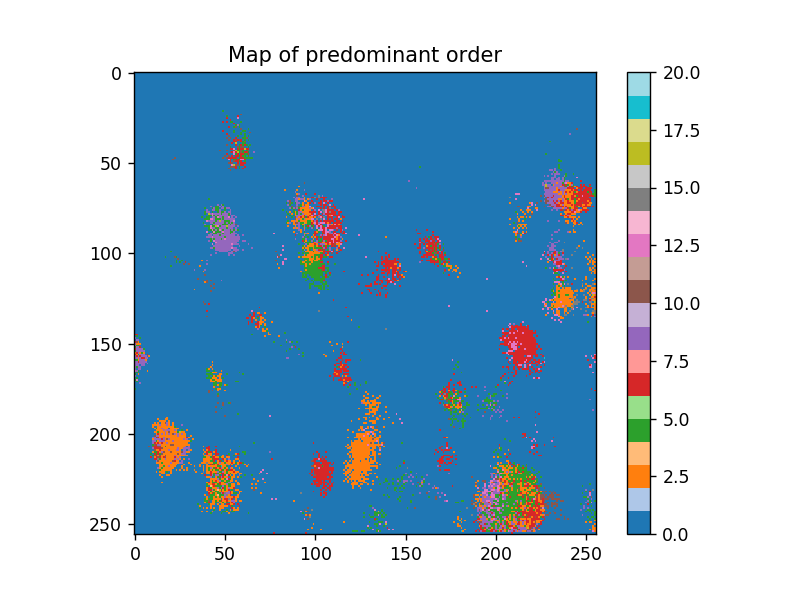

Text(0.5, 1.0, 'Map of predominant order')

In [16]:
# We determine which order is predominant
# We reject values below a threshold to eliminate noise
# Limit to 20 orders for colormap and only use "typical crystalline" orders
# 2, 4, 6 to determine the threshold.
below_threshold = absmaps[1:20] < absmaps[(2, 4, 6), ...].max() * 0.5
below_threshold = np.all(below_threshold, axis=0)
dominant = np.argmax(absmaps[1:20], axis=0) + 1
dominant[below_threshold] = 0

fig, axes = plt.subplots()
plt.imshow(dominant, cmap=cm.tab20, vmin=0, vmax=20)
plt.colorbar()
plt.title("Map of predominant order")